# Steps to Tackle a Time Series Problem (with Codes in Python)
Note: codes adapted / summarized from [article](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

This notebook includes additional code in order to:
1. forecast out of sample periods
2. evaluate model on oyt of sample data

## Loading and Handling TS in Pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
#Note: aim is not to teach stock price forecasting. It's a very complex domain and I have almost no clue about it. Here I will demonstrate the various techniques which can be used for time-series forecasting
data = pd.read_csv('../data/AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


Reading as datetime format:

In [3]:
#data = pd.read_csv('../data/AirPassengers.csv')
data = pd.read_csv('../data/international-airline-passengers.csv', engine='python', skipfooter=3)
data.columns = ['Month', '#Passengers']
data['Month'] = pd.to_datetime(data['Month'],format='%Y-%m')
data.set_index('Month', inplace=True)
data.info()
#data['#Passengers']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
data.dtypes

#Passengers    int64
dtype: object

In [5]:
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
#convert to time series:
ts_x = data['#Passengers']
ts_x.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [7]:
train_size = int(len(ts_x) * 0.67)
test_size = len(ts_x) - train_size
train, test = ts_x[0:train_size], ts_x[train_size:len(ts_x)]
print(train.head(), '\n', len(train), type(train), '\n')
print(test.head(), '\n', len(test), type(test), '\n')

print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

ts = train

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64 
 96 <class 'pandas.core.series.Series'> 

Month
1957-01-01    315
1957-02-01    301
1957-03-01    356
1957-04-01    348
1957-05-01    355
Name: #Passengers, dtype: int64 
 48 <class 'pandas.core.series.Series'> 

Observations: 144
Training Observations: 96
Testing Observations: 48


# Checking for stationarity

## Plot the time-series

### Function for testing stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\Santiago\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Santiago\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


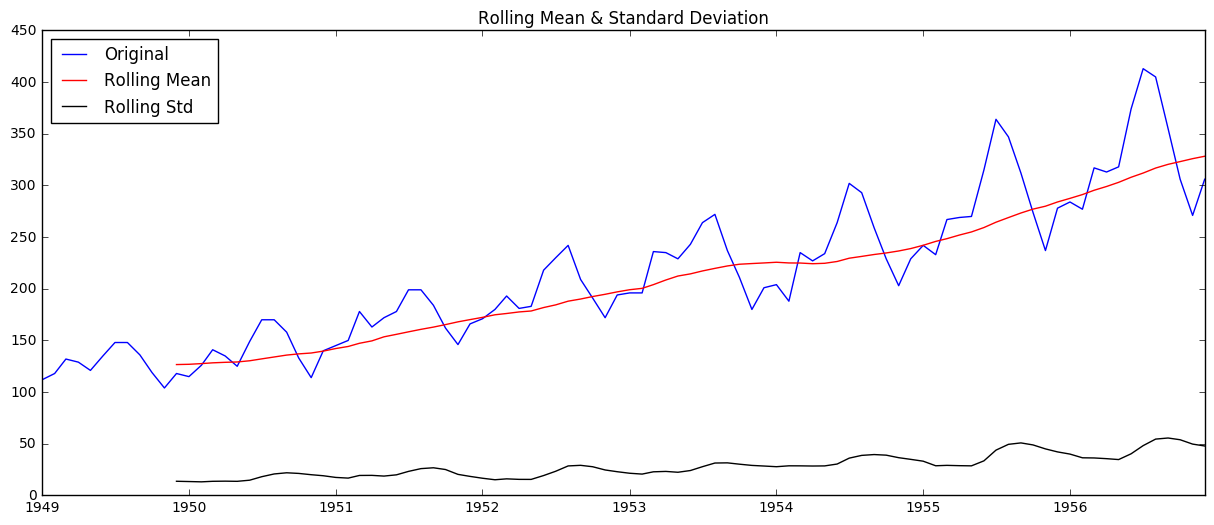

Results of Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [9]:
test_stationarity(ts)

# Making TS Stationary


## Estimating & Eliminating Trend


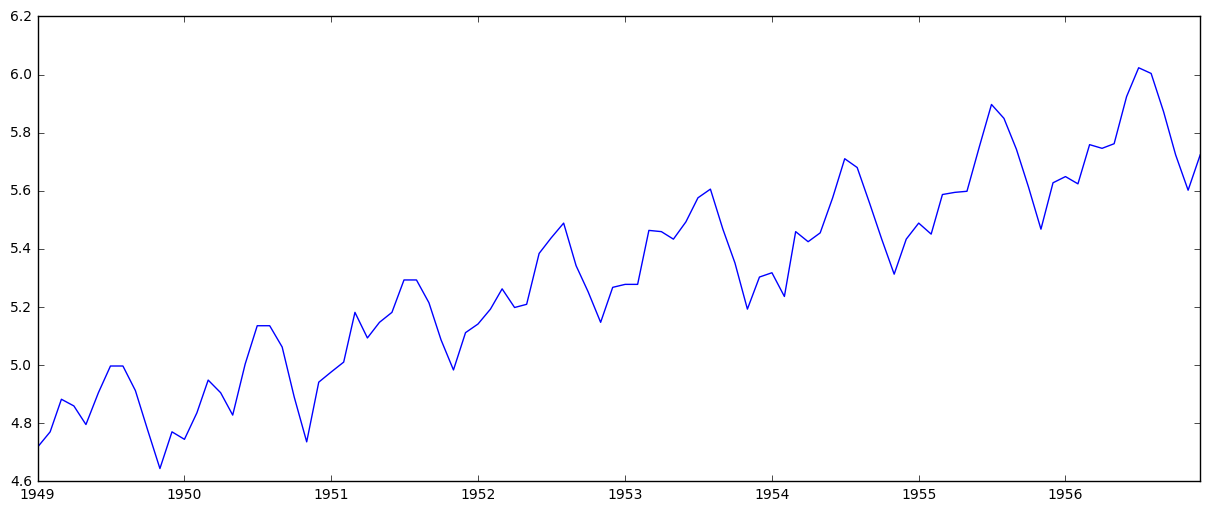

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Techinques to remove trend

Idea: To estimate or model the trend. The estimated trend will be used to remove it from the serie so the serie become ready for fitting a model.

1. **Aggregation** – taking average for a time period like monthly/weekly averages
2. **Smoothing** – taking rolling averages
3. **Polynomial Fitting** – fit a regression model


## Smoothing techniques (2)

a. **Moving average**
```python
# take the average over the past 1 year
moving_avg = pd.rolling_mean(ts_log,12)
# remove trend from the serie
ts_log_moving_avg_diff = ts_log - moving_avg
```
A drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number.


b. **Exponential weighted moving average**
```python
expwighted_avg = pd.ewma(ts_log, halflife=12)
ts_log_ewma_diff = ts_log - expwighted_avg
```
We take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. Find details [here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions).

## Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1. **Differencing** – taking the difference with a particular time lag

  **One of the most common methods of dealing with both trend and seasonality is differencing**. In this technique, we take the 
difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

2. **Decomposition** – modeling both trend and seasonality and removing them from the model.

  In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned (i.e., residuals).

  Converting the residuals into original values for future data in not very intuitive in this case.


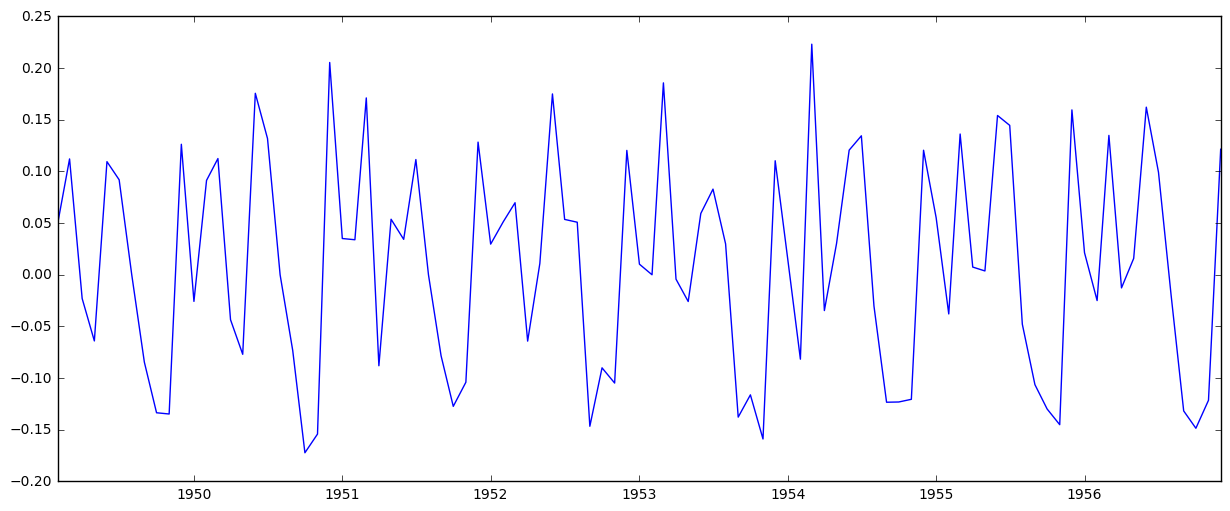

In [11]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

C:\Users\Santiago\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\Santiago\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


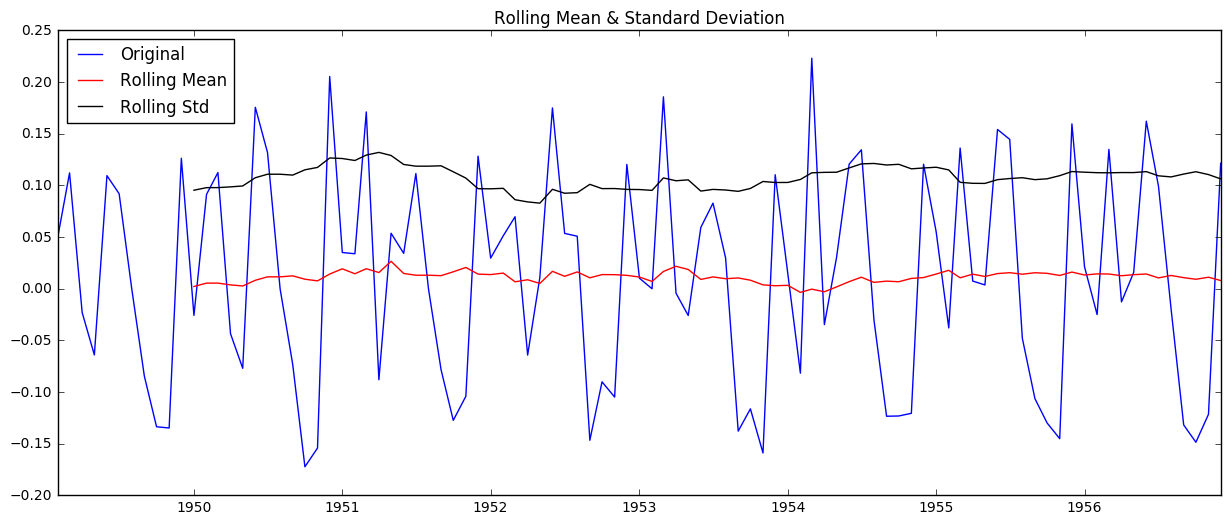

Results of Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [12]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Final Forecasting

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model.

In [13]:
from statsmodels.tsa.arima_model import ARIMA

### ACF & PACF Plots

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1. **p** – The lag value where the **PACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. **q** – The lag value where the **ACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

### Correlogram (ACF)

The light blue area is the 95% condifence band. Dots are the autocorrelation/partial autocorrelation values.

??? The autocorrelation at lag 2 is the first insde the the significance bound ???

**Intuition: example stock price, the stock price at a given lag, should be estimated based on 1 previous lag? or the 2 previous lags? 3 previous lags?**

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.iloc[13:], lags=40, ax=ax2)

### Competing models: AR, MA, ARIMA

* **AR Model**

  **y** values depends only on its own **p** past values. Represented as **AR(p)**, Where **p** is the number of **past values**

  AR(p) equivalent to ARIMA(p,d,0)
  

* **MA Model**

  **y** values depends only on the random error terms which follows a white noise process. Represented as **MA(q)**, Where **q** is the number of **past values**

  MA(q) equivalent to ARIMA(0,d,q)
  

* **ARIMA Model**
  model = ARIMA(**TS**, order=(**p**, **d**, **q**))

  The 'd' param is the order of differencing that the ARIMA algorithm will apply on the timeseries data and this order can be 0 (no-differencing) or another number.
  Since we have variable ts_log_diff with differencing of 1 already computed, then:

```python
model = ARIMA(ts_log_diff, order=(2, 0, 2))
```
  produce same result as:
```python
model = ARIMA(ts_log, order=(2, 1, 2))
```

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Santiago\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


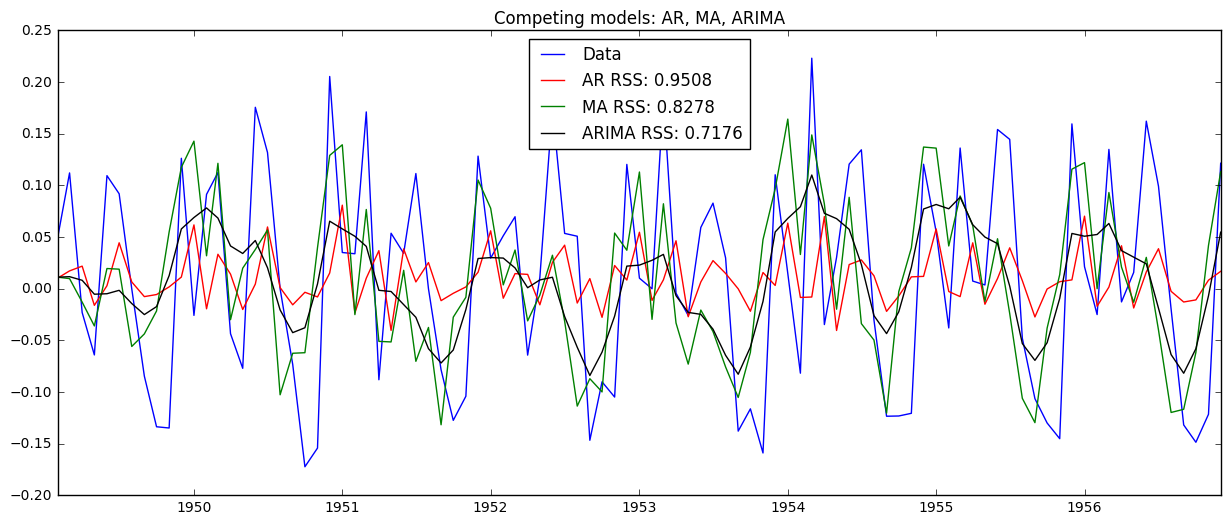

In [14]:
# AR model
model = ARIMA(ts_log, order=(2, 1, 0))
results_AR = model.fit(disp=-1)
# MA model
model = ARIMA(ts_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
# ARIMA model
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)

orig = plt.plot(ts_log_diff, color='blue', label='Data')
ar_plt = plt.plot(results_AR.fittedvalues, color='red', label='AR RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
ma_plt = plt.plot(results_MA.fittedvalues, color='green', label='MA RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
arima_plt = plt.plot(results_ARIMA.fittedvalues, color='black', label='ARIMA RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend(loc='best')
plt.title('Competing models: AR, MA, ARIMA')

ARIMA beats AR and MA judging by RSS. What about AIC?

In [ ]:
# Best AIC
AICs = {'AR':results_AR.aic, 'MA':results_MA.aic, 'ARIMA':results_ARIMA.aic}

print (min(AICs.items(), key=lambda x: x[1]))

### Convert to original scale:

In [ ]:
def restore_trend_and_seasonality(starting_value, fittedvalues, ix):
    predictions_ARIMA_cumsum = fittedvalues.cumsum()
    fit_ARIMA_log =  pd.Series(starting_value, index=ix)
    fit_ARIMA_log = fit_ARIMA_log.add(fittedvalues.cumsum(),fill_value=0)
    return fit_ARIMA_log

In [ ]:
predictions_ARIMA_log = restore_trend_and_seasonality(ts_log.ix[0], results_ARIMA.fittedvalues, ts_log.index)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

In [ ]:
# plot (still in log scale)
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

In [ ]:
# plot at original scale
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

# Future forecasts

In order to generate future forecasts, use a dataframe wich will contains next 12 periods following the last period in sample

In [ ]:
# last period:
ts_log.tail(1)

In [ ]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("1961-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]

X = data[:len(ts)]

future = pd.DataFrame(index=date_list, columns= X.columns)
df = pd.concat([X, future])

In [ ]:
last_ix = len(ts) - 1
periods_to_forecast = 12

# forecast period
p_start = last_ix+1
p_end = last_ix+periods_to_forecast

# predict out of sample periods
forecast =  results_ARIMA.predict(start=p_start, end=p_end, dynamic=True)

# restore trend and seasonality
forecast_ARIMA_log = restore_trend_and_seasonality(ts_log.ix[last_ix], forecast, ts_log.index)

# restore to original scale by taking exp
forecast_ARIMA = np.exp(forecast_ARIMA_log)

print (forecast_ARIMA)

df['forecast'] = forecast_ARIMA

In [ ]:
df.plot(figsize=(12,8))

In [ ]:
df[['#Passengers', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 